# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Прикладные задачи анализа данных" </center>

# <center> Лабораторная работа №2. Рекомендательные системы </center>

* В данной лабораторной работе вам предлагается разработать алгоритм рекомендации фильмов.  
* Рекомендацией пользователю будем считать подборку из 10 фильмов.  
* Ожидаемый результат - эти фильмы пользователю понравятся и он высоко их оценит (weak assumption). 

### Задания  
  
1. Выполните разведывательный анализ данных (EDA).  
2. Разработайте алгоритм рекомендации фильмов пользователю. Используйте различные подходы: collaborative filtering (user to user, item to item), content-based, гибридный.  
3. Предложите способ оценки качества алгоритма и оцените качество различных подходов и моделей из предыдущего пункта.  
4. Опишите недостатки и ограничения предложенных вами моделей/алгоритмов и предложите возможные решения для борьбы с ними. 

### Данные 

Данные находятся в архиве `ml-latest-small.zip`.  
Они представляют из себя оценки 9742 фильмов, выставленные 610 пользователями. 
Также для некоторых фильмов известна информация о жанрах в виде тегов.

**Tip:** Вы можете самостоятельно добыть дополнительную информацию о фильмах, используя открытые (или закрытые) источники. Например, данные с IMDb, для взаимодействия с которой есть [специальный модуль](https://github.com/alberanid/imdbpy).  
**NB:** Использование дополнительных данных положительно скажется на оценке.

In [1]:
with open('data/README.txt') as f:
    desc = f.read()

print(desc)

Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for down

In [2]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Обработка 1

Возьмем информацию с сайта IMDb о режиссере фильма и 2 главных актерах фильма

In [3]:
# Обработка links.csv
#from imdb import IMDb

#ia = IMDb()
#links = pd.read_csv("data/links.csv").loc[:, 'movieId':'imdbId']
#for i, row in links.iterrows():
#    if i%2000==0:
#        print(str(i)+" rows are processed")
#    movie = ia.get_movie(row["imdbId"])
#    try:
#        actor1 = movie['cast'][0].personID.strip("0")
#        links.at[i,'actor1'] = actor1
#    except Exception:
#       actor1 = None
#        links.at[i,'actor1'] = None
#    try:
#        actor2 = movie['cast'][1].personID.strip("0")
#        links.at[i,'actor2'] = actor2
#    except Exception:
#        actor2 = None
#        links.at[i,'actor2'] = None
#    try:
#        director = movie['directors'][0].personID.strip("0")
#        links.at[i,'director'] = director
#    except Exception:
#        director = None
#        links.at[i,'director'] = None      
#links.head()
links.to_csv("data/links_db.csv", sep=',', encoding='utf-8', index=False)

links = pd.read_csv("data/links_db.csv")
links.fillna(value=0, inplace=True)
links=links.astype(int)
links.head()

,movieId,imdbId,actor1,actor2,director
0,1,114709,158,741,165472
1,2,113497,245,404993,165472
2,3,113228,527,493,165472
3,4,114885,1365,291,165472
4,5,113041,188,473,165472


Загрузим информацию о названии и жанрах фильмов из movies.csv и выделим нужные нам параметры

In [4]:
def year(valYear):
    if valYear:
        return int(valYear[0:4])
    else:
        return 0

movies = pd.read_csv("data/movies.csv") 
movies[['movietitle','year']] = movies['title'].str.split("(.*) \((.*)\)",expand=True,).loc[:,1:2]
movies['year']=movies['year'].apply(year)
x=movies['genres'].replace('(no genres listed)','None').str.split("|",expand=True,)
x.fillna(value="None", inplace=True)
colum = pd.unique(x.values.ravel('K'))[:-1]
genre_table = pd.DataFrame(data=x,columns=colum)
for i in range(x.shape[0]):
    for j in range(len(x.columns)):
        cols = x.iloc[i, j]
        genre_table.loc[genre_table.index[i], cols]=1
genre_table = genre_table.iloc[:,:-2]
genre_table.fillna(value=0, inplace=True)
genre_table = genre_table.astype(int)
movies = movies.join(genre_table)
del movies['genres']
del movies['title']
movies.head()

,movieId,movietitle,year,Adventure,Comedy,Action,Drama,Crime,Children,Mystery,...,Documentary,Thriller,Horror,Fantasy,Western,Film-Noir,Romance,Sci-Fi,Musical,War
0,1,Toy Story,1995,1,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,2,Jumanji,1995,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,Waiting to Exhale,1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,Father of the Bride Part II,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
import datetime

def convert_time(timestamp):
    date=datetime.datetime.fromtimestamp(
    int(timestamp)).strftime('%Y-%m-%d %H:%M:%S')
    return int(date[0:4])

# Читаем файл ratings.csv
ratings = pd.read_csv('data/ratings.csv')
# Соединяем таблицы по признаку movieId
movie_db = pd.merge(ratings, movies, on='movieId')
movie_db = pd.merge(movie_db, links, on='movieId')

movie_db['ratingyear']=movie_db['timestamp'].apply(convert_time)
del movie_db['timestamp']

display(movie_db.head(5))

,userId,movieId,rating,movietitle,year,Adventure,Comedy,Action,Drama,Crime,...,Film-Noir,Romance,Sci-Fi,Musical,War,imdbId,actor1,actor2,director,ratingyear
0,1,1,4.0,Toy Story,1995,1,1,0,0,0,...,0,0,0,0,0,114709,158,741,165472,2000
1,5,1,4.0,Toy Story,1995,1,1,0,0,0,...,0,0,0,0,0,114709,158,741,165472,1996
2,7,1,4.5,Toy Story,1995,1,1,0,0,0,...,0,0,0,0,0,114709,158,741,165472,2005
3,15,1,2.5,Toy Story,1995,1,1,0,0,0,...,0,0,0,0,0,114709,158,741,165472,2017
4,17,1,4.5,Toy Story,1995,1,1,0,0,0,...,0,0,0,0,0,114709,158,741,165472,2011


In [6]:
display(movie_db.shape)

(100836, 28)

Получили таблицу с 28 колонками. Запишем информацию в файл movie_db.csv

In [7]:
movie_db.to_csv("data/movie_db.csv", sep=',', encoding='utf-8', index=False)

### Обработка 2

In [8]:
df = pd.read_csv('data/ratings.csv')

In [9]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
movie_titles = pd.read_csv("data/movies.csv")
movie_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
df = pd.merge(df,movie_titles,on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


# EDA


Исследую немного данные и посмотрю на самые оцениваемые фильмы

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Количество пользователей и фильмов:

In [13]:
number_users = movie_db['userId'].unique().shape[0]
number_movies = movie_db['movieId'].unique().shape[0]
print('Users number: {}, Movies number: {}'.format(number_users, number_movies))

Users number: 610, Movies number: 9724


### Как соотносятся средний ретинг и количество оценок?

Cоздам датафрейм рейтингов со средним рейтингом и количеством оценок

In [14]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

In [15]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [16]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [17]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


Выведу несколько гистограмм

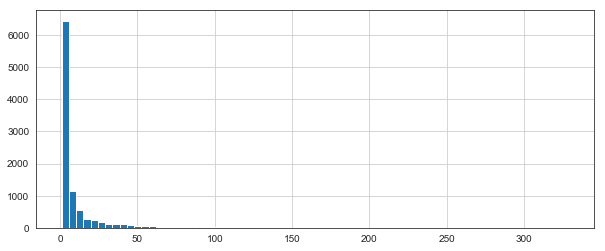

In [18]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

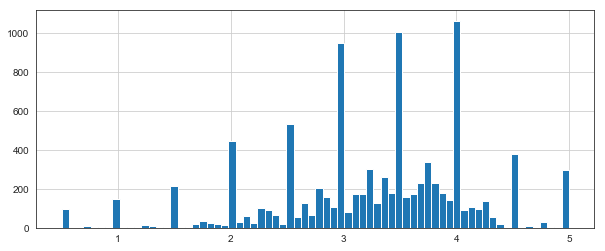

In [22]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

Text(0.5, 0.98, 'Distribution of ratings count')

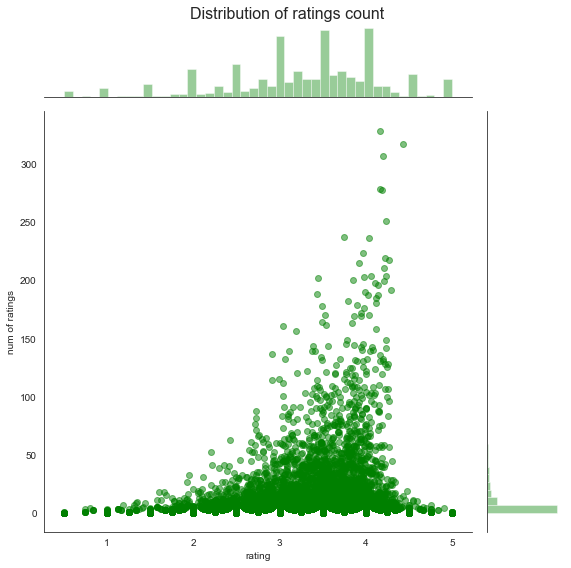

In [20]:
g = sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5, height=8, color='g')
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Distribution of ratings count', fontsize=16)

Видно, что большинство оценок приходятся на промежуток между 3 и 4 баллами и фильмы с высоким рейтингом чаще оцениваются, чем фильмы с низким рейтингом

### Как много фильмов было выпущено за разные года?

Статистика выпущенных за год фильмов

count    106.000000
mean      91.792453
std      102.246734
min        1.000000
25%       16.000000
50%       39.500000
75%      151.500000
max      311.000000
Name: movietitle, dtype: float64


Text(0.5, 1.0, 'Количество выпущенных за год фильмов')

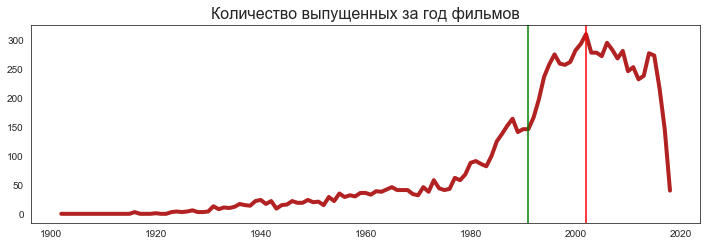

In [182]:
sub=movies[movies['year']!=0]
print("Статистика выпущенных за год фильмов\n")
print(sub.groupby(['year']).count()['movietitle'].describe())
fig1, ax1 = plt.subplots(1,1,figsize=(12,8))
plt.subplot(211)
plt.plot(sub.groupby(['year']).count()['movietitle'],linewidth=4.0,color='firebrick')
plt.axvline(x=1991, color='g')
plt.axvline(x=2002, color='r')
plt.title('Количество выпущенных за год фильмов',fontsize=16)

Видно, что темп роста количества выпущенных за год фильмов стало значительно расти после **1991 года**, а пик приходится на **2002 год** (311 фильмов). Однако информации о фильмах после **2016 года** в датасете становится меньше, а потому видим понижение количества фильмов за год.

### Фильмы каких годов имеют набольшее количество оценок?

Статистика количества оценок фильмов определенных годов

count     106.000000
mean      951.122642
std      1345.813931
min         1.000000
25%        66.750000
50%       256.500000
75%      1426.500000
max      6144.000000
Name: movietitle, dtype: float64


Text(0.5, 1.0, 'Количество оценок фильмов, выпущенных в разные года')

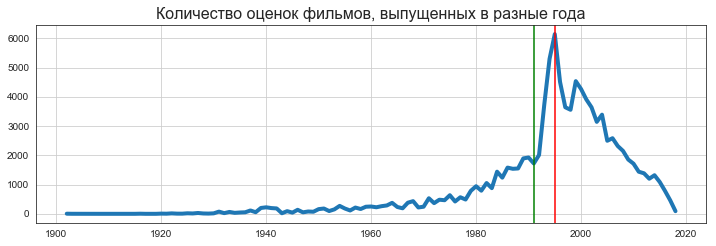

In [73]:
sub=movie_db[movie_db['year']!=0]
print("Статистика количества оценок фильмов определенных годов\n")
print(sub.groupby(['year']).count()['movietitle'].describe())
fig1, ax1 = plt.subplots(1,1,figsize=(12,8))
plt.subplot(211)
plt.plot(sub.groupby(['year']).count()['movietitle'],linewidth=4.0)
plt.axvline(x=1991, color='g')
plt.axvline(x=1995, color='r')
plt.grid(True)
plt.title('Количество оценок фильмов, выпущенных в разные года',fontsize=16)

Видно, что аналогично больше всего оценок имеют фильмы, выпущенные после **1991 года**, а пик приходится на **1995 год** (6144 оценок). Посмотрим примеры фильмов в этом году

In [70]:
for x in sub.loc[sub['year'] == 1995]['movietitle'].unique()[0:10]:
    print(x)

Toy Story
Grumpier Old Men
Heat
Seven (a.k.a. Se7en)
Usual Suspects, The
Braveheart
Rob Roy
Canadian Bacon
Desperado
Billy Madison


### В какие года пользователи ставили набольшее количество оценок?

Статистика количества оценок фильмов за год

count       23.000000
mean      4384.173913
std       2418.806555
min        507.000000
25%       2369.500000
50%       4059.000000
75%       6229.000000
max      10061.000000
Name: userId, dtype: float64


Text(0.5, 1.0, 'Количество оценок фильмов за год')

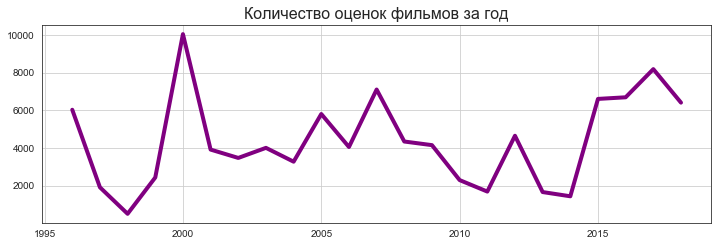

In [181]:
sub=movie_db[movie_db['ratingyear']!=0]
print("Статистика количества оценок фильмов за год\n")
print(sub.groupby(['ratingyear']).count()['userId'].describe())
fig1, ax1 = plt.subplots(1,1,figsize=(12,8))
plt.subplot(211)
plt.plot(sub.groupby(['ratingyear']).count()['userId'],linewidth=4.0,color='purple')
plt.grid(True)
plt.title('Количество оценок фильмов за год',fontsize=16)

Набольшее количество оценок было выставлено в **2000 году** (около 100 тыс.) после чего их количество варировалось **от 2 до 7 тыс.** и в 2017 достигло **8 тыс.** оценок

### Как менялась средняя оценка фильмов, выпущенных в разные года?

Статистика средних оценок фильмов за год

           rating
count  106.000000
mean     3.637577
std      0.336265
min      2.000000
25%      3.490903
50%      3.650452
75%      3.817205
max      4.500000


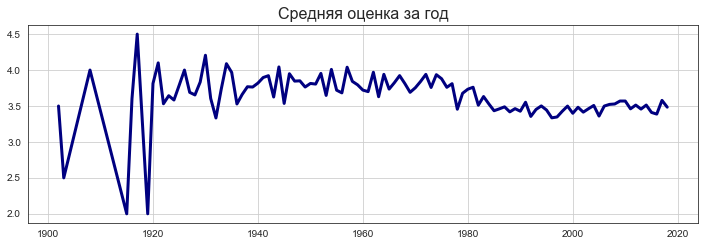

In [184]:
sub=movie_db[movie_db['year']!=0]
avg_rates_year=sub[['year','rating']].groupby('year').mean()
print("Статистика средних оценок фильмов за год\n")
print(avg_rates_year.describe())
fig2, ax2 = plt.subplots(1,1,figsize=(12,8))
plt.subplot(211)
a2=plt.plot(avg_rates_year,linewidth=3.0,color='navy')
plt.title('Средняя оценка за год',fontsize=16)
plt.grid(True)

Насколько мы видим, есть тенденция постепенного уменьшения значения средних оценок фильмов.

### Какие жанры фильмов наиболее популярны?

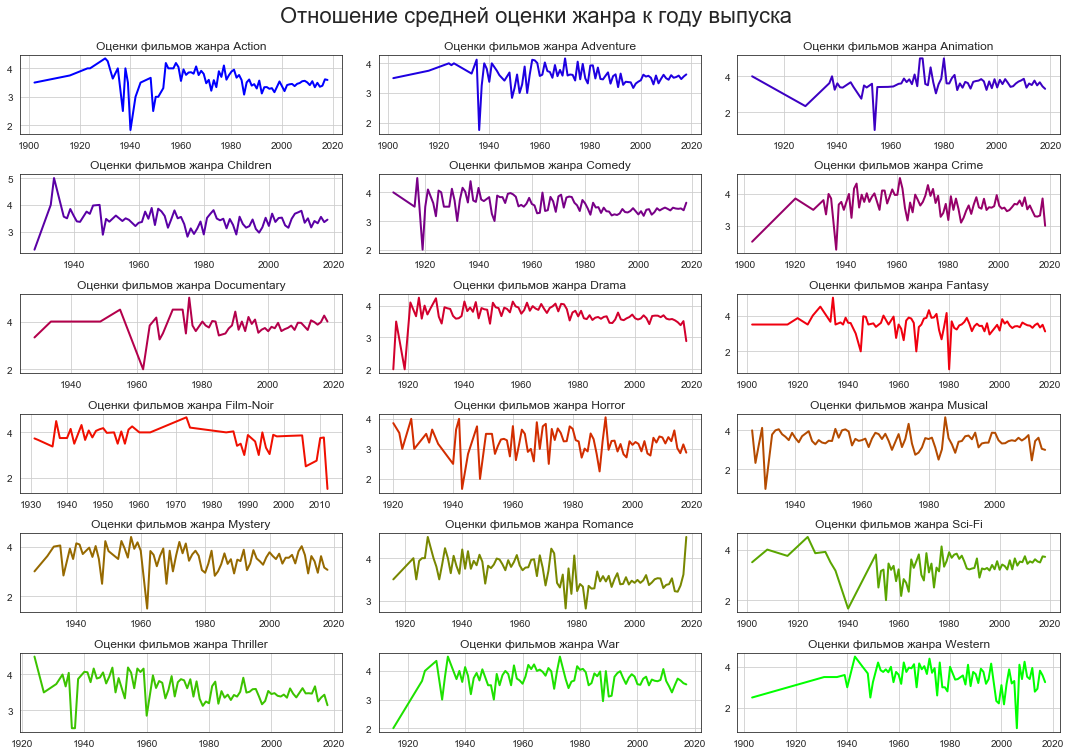

In [186]:
cmap = plt.get_cmap('brg')
all_genres=['Action','Adventure','Animation',"Children",
 "Comedy","Crime","Documentary","Drama",
 "Fantasy",'Film-Noir','Horror','Musical',
 'Mystery','Romance','Sci-Fi','Thriller',
 'War','Western']
colors = cmap(np.linspace(0, 1, len(all_genres)))

sub=movie_db[movie_db['year']!=0]
fig, axes = plt.subplots(6,3,figsize=(15,11))
fig.suptitle('Отношение средней оценки жанра к году выпуска', fontsize=22)
for i, (genre, col) in enumerate(zip(all_genres, colors), 1):
    avg_rates_year=sub.loc[sub[genre] == 1][['year','rating']].groupby('year').mean()
    axes[(i-1)//3, (i-1)%3].plot(avg_rates_year,linewidth=2.0, color=col)
    axes[(i-1)//3, (i-1)%3].title.set_text('Оценки фильмов жанра %s'%genre)    
    axes[(i-1)//3, (i-1)%3].grid(True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

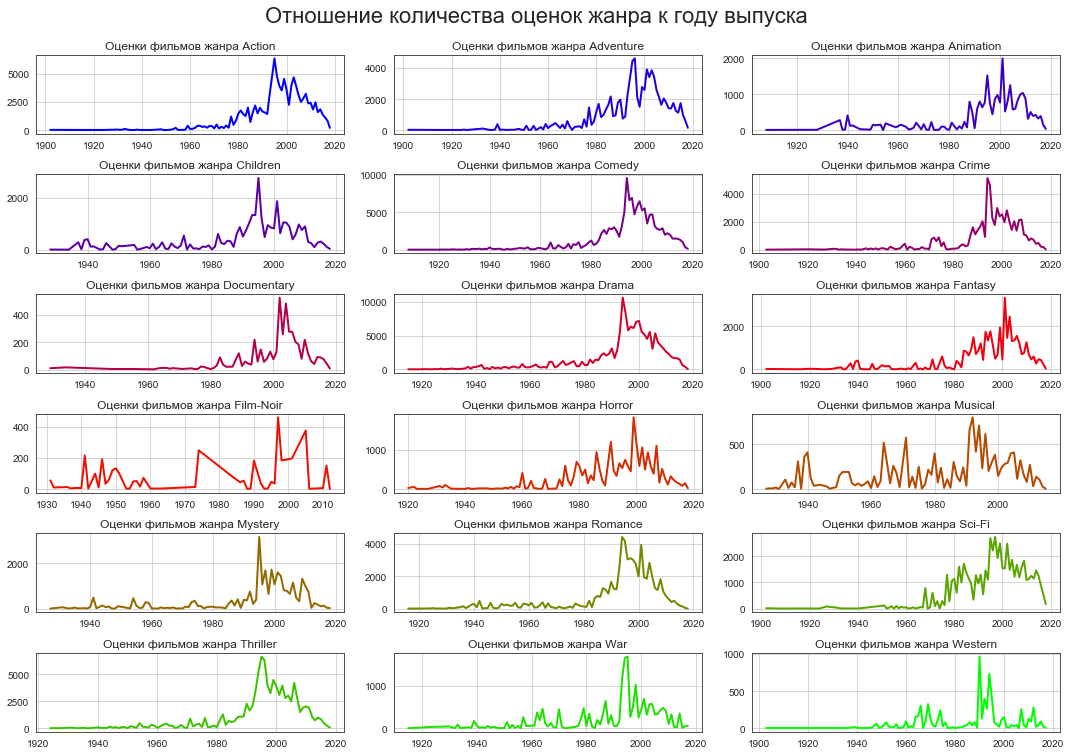

In [187]:
sub=movie_db[movie_db['year']!=0]
fig, axes = plt.subplots(6,3,figsize=(15,11))
fig.suptitle('Отношение количества оценок жанра к году выпуска', fontsize=22)
for i, (genre, col) in enumerate(zip(all_genres, colors), 1):
    avg_rates_year=sub.loc[sub[genre] == 1][['year','rating']].groupby('year').sum()
    axes[(i-1)//3, (i-1)%3].plot(avg_rates_year,linewidth=2.0, color=col)
    axes[(i-1)//3, (i-1)%3].title.set_text('Оценки фильмов жанра %s'%genre)    
    axes[(i-1)//3, (i-1)%3].grid(True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Как влияют разные актеры на рейтинг фильмов?

Посмотрим на зависимость между средней оценкой фильма и актером, который играет в нём главную роль

In [286]:
from imdb import IMDb

u=movie_db.groupby(['actor1']).apply(lambda x: x['rating'].sum()/x['rating'].count())
v=movie_db.groupby(['actor1']).apply(lambda x: x['actor1'].count())
data = pd.DataFrame({'mean_rating': u,'count':v,'actor1':u.index})
ia = IMDb()
print("\nЛучшие актеры, имеющие более 5 оценок")
for i, row in data.loc[data['count']>5].sort_values(by=['mean_rating'], ascending=False)[0:5].iterrows():
    id =int(data.at[i,'actor1'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])
print("\nЛучшие актеры, имеющие более 20 оценок")
for i, row in data.loc[data['count']>20].sort_values(by=['mean_rating'], ascending=False)[0:5].iterrows():
    id =int(data.at[i,'actor1'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])


Лучшие актеры, имеющие более 5 оценок
Vasiliy Livanov  Mean Rating:  4.8125  Count of ratings:  8
Giancarlo Giannini  Mean Rating:  4.666666666666667  Count of ratings:  6
Timothy Spall  Mean Rating:  4.590909090909091  Count of ratings:  11
Frank Welker  Mean Rating:  4.571428571428571  Count of ratings:  7
Helena Bonham Carter  Mean Rating:  4.5  Count of ratings:  7

Лучшие актеры, имеющие более 20 оценок
Tatsuya Nakadai  Mean Rating:  4.327586206896552  Count of ratings:  29
Alison Crosbie  Mean Rating:  4.3  Count of ratings:  25
William Gates  Mean Rating:  4.293103448275862  Count of ratings:  29
Ruth Gordon  Mean Rating:  4.288461538461538  Count of ratings:  26
Stephen Baldwin  Mean Rating:  4.228155339805825  Count of ratings:  206


In [287]:
print("\nЛучшие актеры, имеющие более 50 оценок")  
for i, row in data.loc[data['count']>50].sort_values(by=['mean_rating'], ascending=False)[0:5].iterrows():
    id =int(data.at[i,'actor1'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])
print("\nЛучшие актеры, имеющие более 100 оценок")   
for i, row in data.loc[data['count']>100].sort_values(by=['mean_rating'], ascending=False)[0:5].iterrows():
    id =int(data.at[i,'actor1'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])


Лучшие актеры, имеющие более 50 оценок
Stephen Baldwin  Mean Rating:  4.228155339805825  Count of ratings:  206
F. Murray Abraham  Mean Rating:  4.184210526315789  Count of ratings:  76
Jonathan Pryce  Mean Rating:  4.177966101694915  Count of ratings:  59
Mark Hamill  Mean Rating:  4.1711309523809526  Count of ratings:  672
Tim Roth  Mean Rating:  4.170347003154574  Count of ratings:  317

Лучшие актеры, имеющие более 100 оценок
Stephen Baldwin  Mean Rating:  4.228155339805825  Count of ratings:  206
Mark Hamill  Mean Rating:  4.1711309523809526  Count of ratings:  672
Tim Roth  Mean Rating:  4.170347003154574  Count of ratings:  317
Audrey Tautou  Mean Rating:  4.152671755725191  Count of ratings:  131
Kate Sanford  Mean Rating:  4.118918918918919  Count of ratings:  185


In [288]:
print("\nЛучшие актеры, имеющие более 500 оценок")  
for i, row in data.loc[data['count']>500].sort_values(by=['mean_rating'], ascending=False)[0:5].iterrows():
    id =int(data.at[i,'actor1'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])
print("\nЛучшие актеры, имеющие более 1000 оценок")   
for i, row in data.loc[data['count']>1000].sort_values(by=['mean_rating'], ascending=False)[0:5].iterrows():
    id =int(data.at[i,'actor1'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])


Лучшие актеры, имеющие более 500 оценок
Mark Hamill  Mean Rating:  4.1711309523809526  Count of ratings:  672
Tim Robbins  Mean Rating:  4.107142857142857  Count of ratings:  504
Christian Bale  Mean Rating:  3.877208480565371  Count of ratings:  566
Leonardo DiCaprio  Mean Rating:  3.8031453362255965  Count of ratings:  922
Tom Hanks  Mean Rating:  3.7816582914572865  Count of ratings:  1990

Лучшие актеры, имеющие более 1000 оценок
Tom Hanks  Mean Rating:  3.7816582914572865  Count of ratings:  1990
Harrison Ford  Mean Rating:  3.7237654320987654  Count of ratings:  1296
Johnny Depp  Mean Rating:  3.5379924953095685  Count of ratings:  1066
Bruce Willis  Mean Rating:  3.5066607460035524  Count of ratings:  1126
Arnold Schwarzenegger  Mean Rating:  3.5064786585365852  Count of ratings:  1312


Видно, как с увеличением количество оценок фильма, растет узнаваемость актера, который играл в нём главную роль. Если **Timothy Spall** и **Giancarlo Giannini** не так известны, то в известности **Harrison Ford** и **Tom Hanks** нет никаких сомнений.

Дополнительно посмотрим на актеров играющих вторую после главной роль:

In [290]:
from imdb import IMDb

u=movie_db.groupby(['actor2']).apply(lambda x: x['rating'].sum()/x['rating'].count())
v=movie_db.groupby(['actor2']).apply(lambda x: x['actor2'].count())
data = pd.DataFrame({'mean_rating': u,'count':v,'actor2':u.index})
ia = IMDb()
print("\nЛучшие вторые актеры, имеющие более 50 оценок")
for i, row in data.loc[data['count']>50].sort_values(by=['mean_rating'], ascending=False)[0:5].iterrows():
    id =int(data.at[i,'actor2'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])
print("\nЛучшие вторые актеры, имеющие более 300 оценок")
for i, row in data.loc[data['count']>300].sort_values(by=['mean_rating'], ascending=False)[0:5].iterrows():
    id =int(data.at[i,'actor2'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])


Лучшие вторые актеры, имеющие более 50 оценок
George C. Scott  Mean Rating:  4.268041237113402  Count of ratings:  97
George Kennedy  Mean Rating:  4.232758620689655  Count of ratings:  58
Edward Furlong  Mean Rating:  4.203846153846154  Count of ratings:  130
Louise Fletcher  Mean Rating:  4.203007518796992  Count of ratings:  133
Amanda Plummer  Mean Rating:  4.192556634304207  Count of ratings:  309

Лучшие вторые актеры, имеющие более 300 оценок
Amanda Plummer  Mean Rating:  4.192556634304207  Count of ratings:  309
Rebecca Williams  Mean Rating:  4.164133738601824  Count of ratings:  329
Harrison Ford  Mean Rating:  4.1242897727272725  Count of ratings:  704
Laurence Fishburne  Mean Rating:  4.079113924050633  Count of ratings:  316
John Cleese  Mean Rating:  4.02435064935065  Count of ratings:  308


Таким образом есть актеры, которые в положительную стороную играют на рейтинг фильм и также увеличивают обсуждаемость фильма

### Как влияет режиссер на рейтинг фильмов?

Аналогичным образом посмотрим на влияние режиссера картины на средний рейтинг фильма

In [ ]:
from imdb import IMDb

u=movie_db.groupby(['director']).apply(lambda x: x['rating'].sum()/x['rating'].count())
v=movie_db.groupby(['director']).apply(lambda x: x['actor2'].count())
data = pd.DataFrame({'mean_rating': u,'count':v,'director':u.index})
ia = IMDb()
print("\nЛучшие режиссеры, имеющие более 50 оценок")
for i, row in data.loc[data['count']>50].sort_values(by=['mean_rating'], ascending=False)[0:6].iterrows():
    id =int(data.at[i,'director'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])
print("\nЛучшие режиссеры, имеющие более 300 оценок")
for i, row in data.loc[data['count']>300].sort_values(by=['mean_rating'], ascending=False)[0:6].iterrows():
    id =int(data.at[i,'director'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])
print("\nЛучшие режиссеры, имеющие более 800 оценок")
for i, row in data.loc[data['count']>800].sort_values(by=['mean_rating'], ascending=False)[0:6].iterrows():
    id =int(data.at[i,'director'])
    print(ia.get_person(id)," Mean Rating: ",data.at[i,'mean_rating']," Count of ratings: ",data.at[i,'count'])

Таким образом известные режиссеры часто имеют много положительных отзывов, повышающих рейтинг фильма

# Collaborative filtering

## Item to item?

In [294]:
import scipy.sparse as sparse

users = list(np.sort(movie_db['userId'].unique())) # Get our unique customers
movies = list(movie_db['movieId'].unique()) # Get our unique products that were purchased
rating = list(movie_db['rating']) # All of our purchases

rows = movie_db['userId'].astype('category', categories = users).cat.codes 
cols = movie_db['movieId'].astype('category', categories = movies).cat.codes 

user_item = sparse.csr_matrix((rating, (rows, cols)), shape=(len(users), len(movies)))

In [295]:
matrix_size = user_item.shape[0]*user_item.shape[1] # Number of possible interactions in the matrix
num_purchases = len(user_item.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (1.0*num_purchases/matrix_size))
sparsity

98.30003169443864

In [321]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=10, 
                                             iterations=20, 
                                             regularization=0.1, 
                                             num_threads=4)
model.fit(user_item.T)

100%|██████████| 20.0/20 [00:01<00:00, 16.60it/s]


In [337]:
from IPython.display import HTML
from IPython.display import display

def similar_items(item_id, movies_table, movies, N=5):

    user_item_id = movies.index(item_id)
    similars = model.similar_items(user_item_id, N=N+1)    
    l = [item[0] for item in similars]
    ids = [movies[ids] for ids in l]
    ids = pd.DataFrame(ids, columns=['movieId'])
    recommendation = pd.merge(ids, movies_table, on='movieId', how='left')    
    return recommendation

def display_similar_items(df):
    images = ''
    for i, row in df.iterrows():
        idx = df.at[i,'movieId']
        ids = movie_db.loc[movie_db['movieId']==idx]['imdbId'].iloc[0]
        mov = ia.get_movie(ids)    
        link = mov['cover url']
        images += "<img style='width: 360px; margin: 0px; \
          float: left; border: 1px solid black;' src='%s' />" \
      % link
    display(HTML(images))

In [338]:
id = movie_db.loc[movie_db['movietitle']=='Die Hard']['movieId']
display_similar_items(similar_items(5628, movie_titles, movies, 10))